In [15]:
%matplotlib inline
import os
import json
import itertools
from glob import glob
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn
import pandas
import yaml
import dinopy

from sh import phasm as phasm_sh

from phasm.io import gfa

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_style("whitegrid")

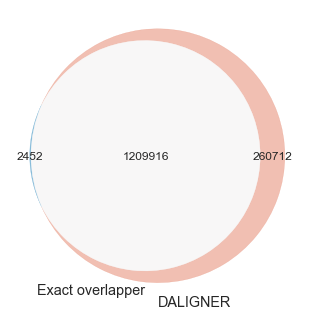

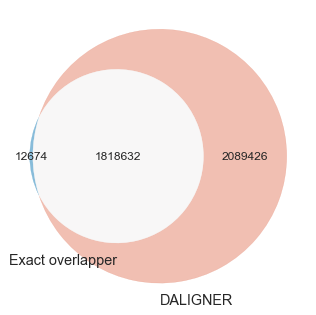

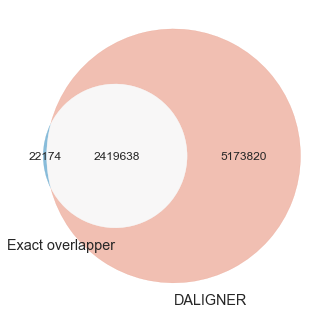

In [14]:
c1, c2, c3 = seaborn.color_palette("RdBu_r", n_colors=3)

for assembly, asm_config in config['assemblies'].items():
    if assembly.endswith('-lh'):
        continue
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if coverage != 60:
        continue
        
    if ploidy > 4:
        continue
        
    exact_gfa = os.path.join(asm_folder, "01_overlap", "exact.gfa")
    daligner_gfa = os.path.join(asm_folder, "01_overlap", "alignments.gfa")
    
    exact_overlaps = set()
    daligner_overlaps = set()
    
    with open(exact_gfa) as f:
        edge_lines = (l for l in f if l.startswith('E'))
        for line in edge_lines:
            sid1, sid2, arange, brange, alignment, tags = gfa.gfa2_parse_edge(line)
            
            # Remove orientation
            read1 = sid1[:-1]
            read2 = sid2[:-1]
            
            exact_overlaps.add((read1, read2))
            exact_overlaps.add((read2, read1))
            
    daligner_in_count = 0
    daligner_out_count = 0
            
    with open(daligner_gfa) as f:
        edge_lines = (l for l in f if l.startswith('E'))
        for line in edge_lines:
            sid1, sid2, arange, brange, alignment, tags = gfa.gfa2_parse_edge(line)
            
            # Remove orientation
            read1 = sid1[:-1]
            read2 = sid2[:-1]
            
            daligner_overlaps.add((read1, read2))
            daligner_overlaps.add((read2, read1))
            
    plt.figure()
    v = venn2(
        [exact_overlaps, daligner_overlaps],
        set_labels=("Exact overlapper", "DALIGNER")
    )
    v.get_patch_by_id('10').set_color(c1)
    v.get_patch_by_id('01').set_color(c3)
    v.get_patch_by_id('11').set_color(c2)
    
    v.get_patch_by_id('10').set_alpha(0.8)
    v.get_patch_by_id('01').set_alpha(0.5)
    v.get_patch_by_id('11').set_alpha(0.8)
    
    
    plt.savefig(os.path.join(BASE_DIR, 'figures', 'exact-vs-daligner-p{}.png'.format(ploidy)))
    
            

In [ ]:
for assembly, asm_config in config['assemblies'].items():
    if assembly.endswith('-lh'):
        continue
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if coverage != 60:
        continue
        
    exact_gfa = os.path.join(asm_folder, "01_overlap", "exact.gfa")
    daligner_gfa = os.path.join(asm_folder, "01_overlap", "alignments.gfa")
    
    exact_layout = os.path.join(asm_folder, "02_layout", "exact.gfa")
    daligner_layout = os.path.join(asm_folder, "02_layout", "daligner.gfa")
    
    phasm_sh.layout("-l", 5000, "-o", exact_layout, "-M", exact_layout + ".json", exact_gfa)
    phasm_sh.layout("-l", 5000, "-o", daligner_layout, "-M", daligner_layout + ".json", daligner_gfa)
        
    